# <h2 style="color:#000000; font-family: 'Segoe UI'; border:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px; text-align:center">   Predicting Heart Disease</h2>

### 🏥 Heart Disease Dataset: Data Dictionary

| 🧬 Column Name | 📝 Description |
| --- | --- |
| **📅 Age** | Age of the patient (in years) |
| **🚻 Sex** | Gender of the patient:<br><br>🔹 `1` = Male<br> <br>🔹 `0` = Female |
| **🫀 Chest pain type** | Type of chest pain experienced:<br><br>🔸 `1` = Typical angina<br><br>🔸 `2` = Atypical angina<br><br>🔸 `3` = Non-anginal pain<br><br>🔸 `4` = Asymptomatic |
| **🩺 BP** | Resting blood pressure (in mm Hg) |
| **🧪 Cholesterol** | Serum cholesterol level (in mg/dL) |
| **🍭 FBS over 120** | Fasting blood sugar > 120 mg/dL:<br><br>✅ `1` = True<br><br>❌ `0` = False |
| **📊 EKG results** | Resting electrocardiogram results:<br><br>🟢 `0` = Normal<br><br>🟡 `1` = ST-T wave abnormality<br><br>🔴 `2` = Left ventricular hypertrophy |
| **⚡ Max HR** | Maximum heart rate achieved during stress |
| **💪 Exercise angina** | Exercise-induced angina:<br><br>🏃 `1` = Yes<br><br>🛑 `0` = No |
| **📉 ST depression** | ST depression induced by exercise relative to rest |
| **📈 Slope of ST** | The slope of the peak exercise ST segment |
| **☢️ Number of vessels fluro** | Number of major vessels (0–3) colored by fluoroscopy |
| **💎 Thallium** | Thallium stress test result (categorical medical indicator) |
| **🎯 Heart Disease** | **Target Variable:**<br><br>⚠️ `Presence` = Heart disease detected<br><br>🛡️ `Absence` = No heart disease |

# <span style="color:#000000; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🔧  Import Libraries</span>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, TargetEncoder, PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler, OneHotEncoder
from scipy import stats
#Imports for Stacking Models
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

# <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🗂️ Load Data</span>


In [2]:
train = pd.read_csv(r"/kaggle/input/playground-series-s6e2/train.csv", index_col = 'id')
test = pd.read_csv(r"/kaggle/input/playground-series-s6e2/test.csv")
sample_submission = pd.read_csv(r"/kaggle/input/playground-series-s6e2/sample_submission.csv", index_col = 'id')

print("train data :", train.shape)
print("test data :", test.shape)
print("sample_submission_data :", sample_submission.shape)

train data : (630000, 14)
test data : (270000, 14)
sample_submission_data : (270000, 1)


# <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  📊 View Data</span>

In [3]:
train.head(3)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence


In [4]:
test.head(3)

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7


In [5]:
train.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  object 
dtypes: float6

In [7]:
train.nunique()

Age                         42
Sex                          2
Chest pain type              4
BP                          66
Cholesterol                150
FBS over 120                 2
EKG results                  3
Max HR                      93
Exercise angina              2
ST depression               66
Slope of ST                  3
Number of vessels fluro      4
Thallium                     3
Heart Disease                2
dtype: int64

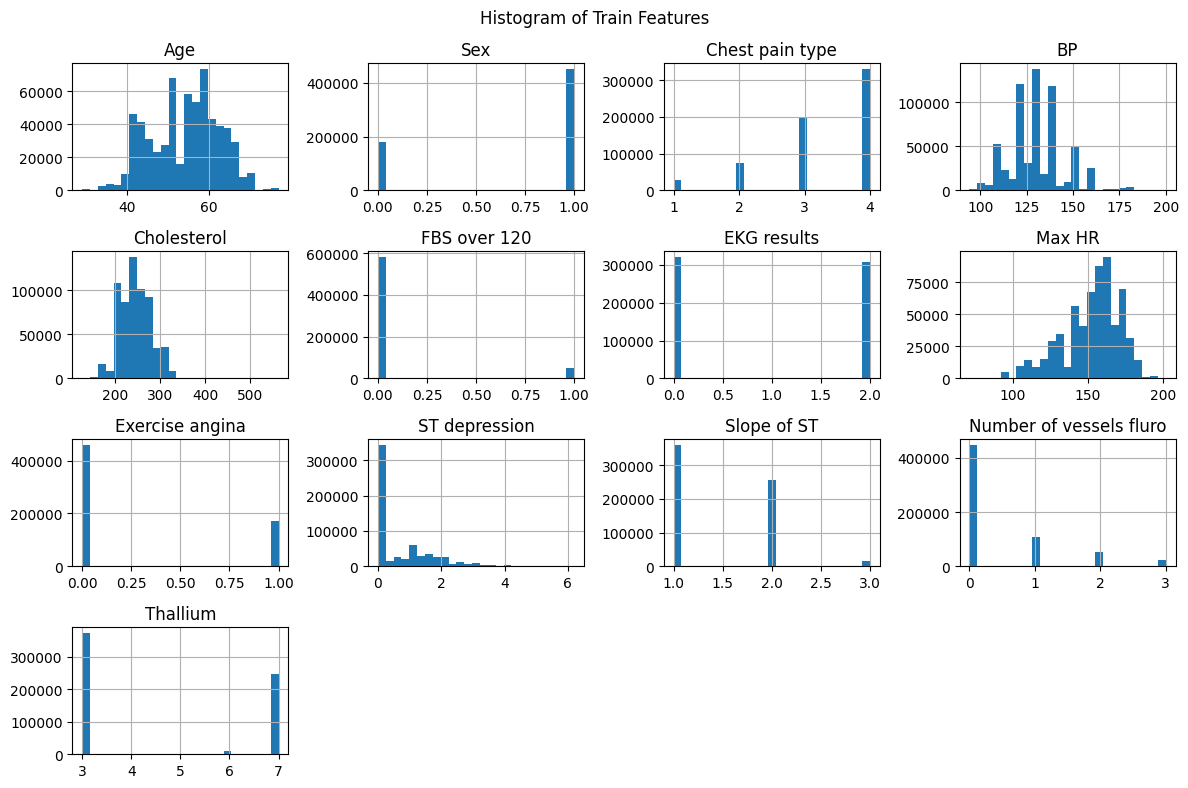

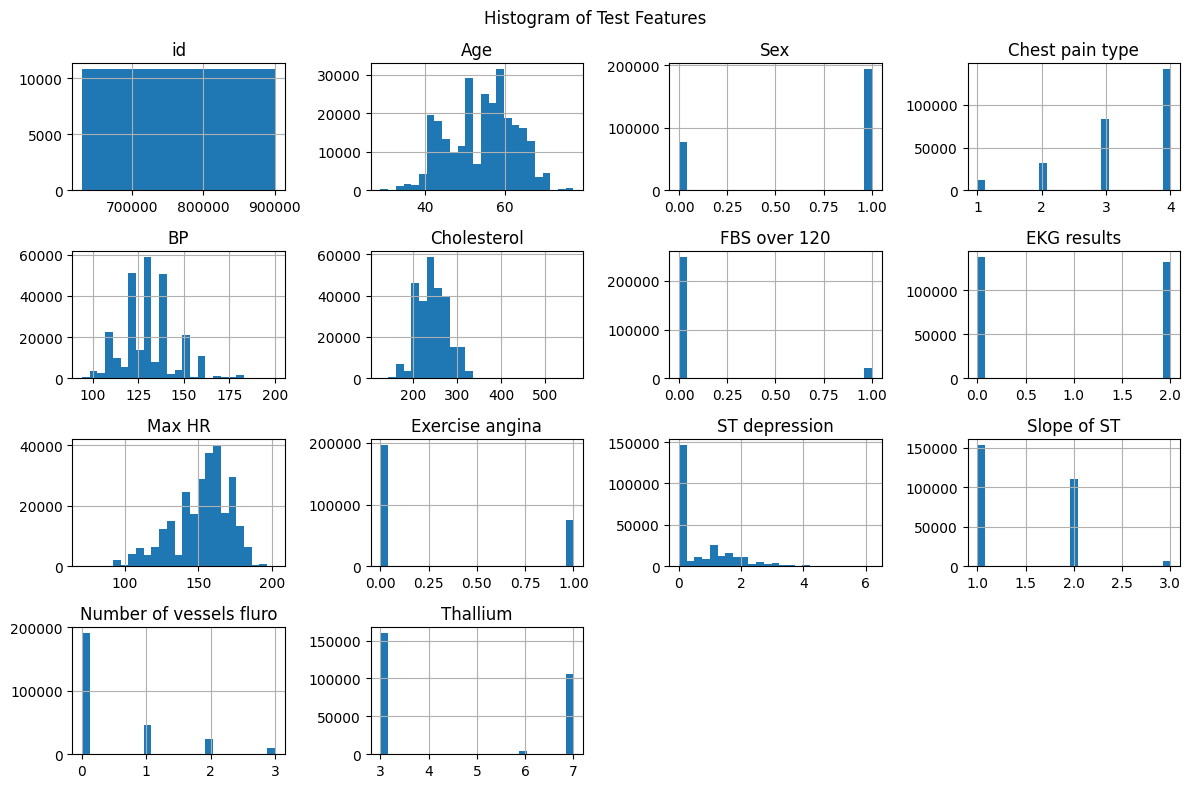

In [8]:
train_cols = train.columns
test_cols = test.columns

# Histogram for train column
train[train_cols].hist(figsize=(12, 8), bins=25)
plt.suptitle("Histogram of Train Features")
plt.tight_layout()
plt.show()


# Histogram for test column
test[test_cols].hist(figsize=(12, 8), bins=25)
plt.suptitle("Histogram of Test Features")
plt.tight_layout()
plt.show()

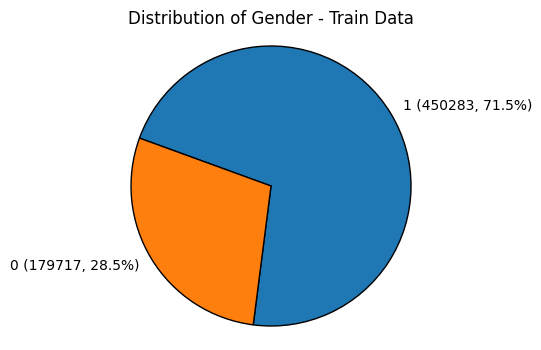

In [9]:
counts = train['Sex'].value_counts()

# Calculate percentages
percentages = (counts / counts.sum()) * 100

# Create labels with both value counts and percentages
labels = [f'{label} ({count}, {perc:.1f}%)' for label, count, perc in zip(counts.index, counts.values, percentages)]

# Create the pie chart
plt.figure(figsize=(6, 4)) # Set figure size for better readability
plt.pie(counts, labels=labels, startangle=160, counterclock=False, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Gender - Train Data')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

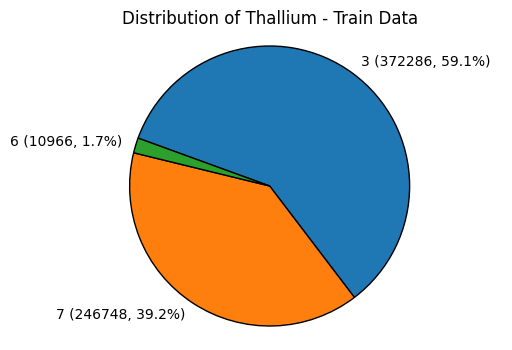

In [10]:
counts = train['Thallium'].value_counts()

# Calculate percentages
percentages = (counts / counts.sum()) * 100

# Create labels with both value counts and percentages
labels = [f'{label} ({count}, {perc:.1f}%)' for label, count, perc in zip(counts.index, counts.values, percentages)]

# Create the pie chart
plt.figure(figsize=(6, 4)) # Set figure size for better readability
plt.pie(counts, labels=labels, startangle=160, counterclock=False, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Thallium - Train Data')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

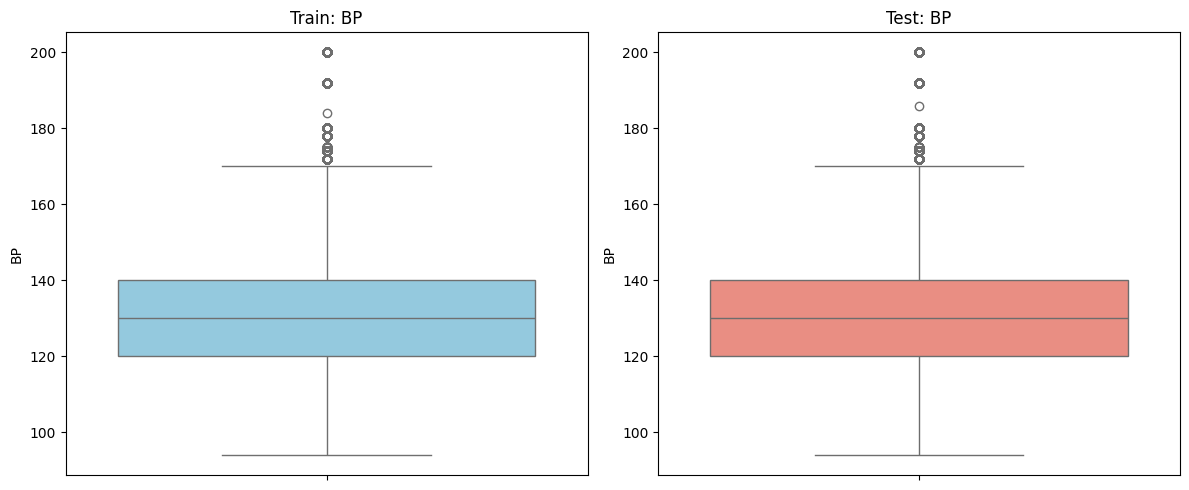

In [11]:
def plot_outliers(train_df, test_df, feature):
    plt.figure(figsize=(12, 5))
    
    # Train Data
    plt.subplot(1, 2, 1)
    sns.boxplot(data=train_df, y=feature, color='skyblue')
    plt.title(f'Train: {feature}')
    
    # Test Data
    plt.subplot(1, 2, 2)
    sns.boxplot(data=test_df, y=feature, color='salmon')
    plt.title(f'Test: {feature}')
    
    plt.tight_layout()
    plt.show()

plot_outliers(train, test, 'BP')

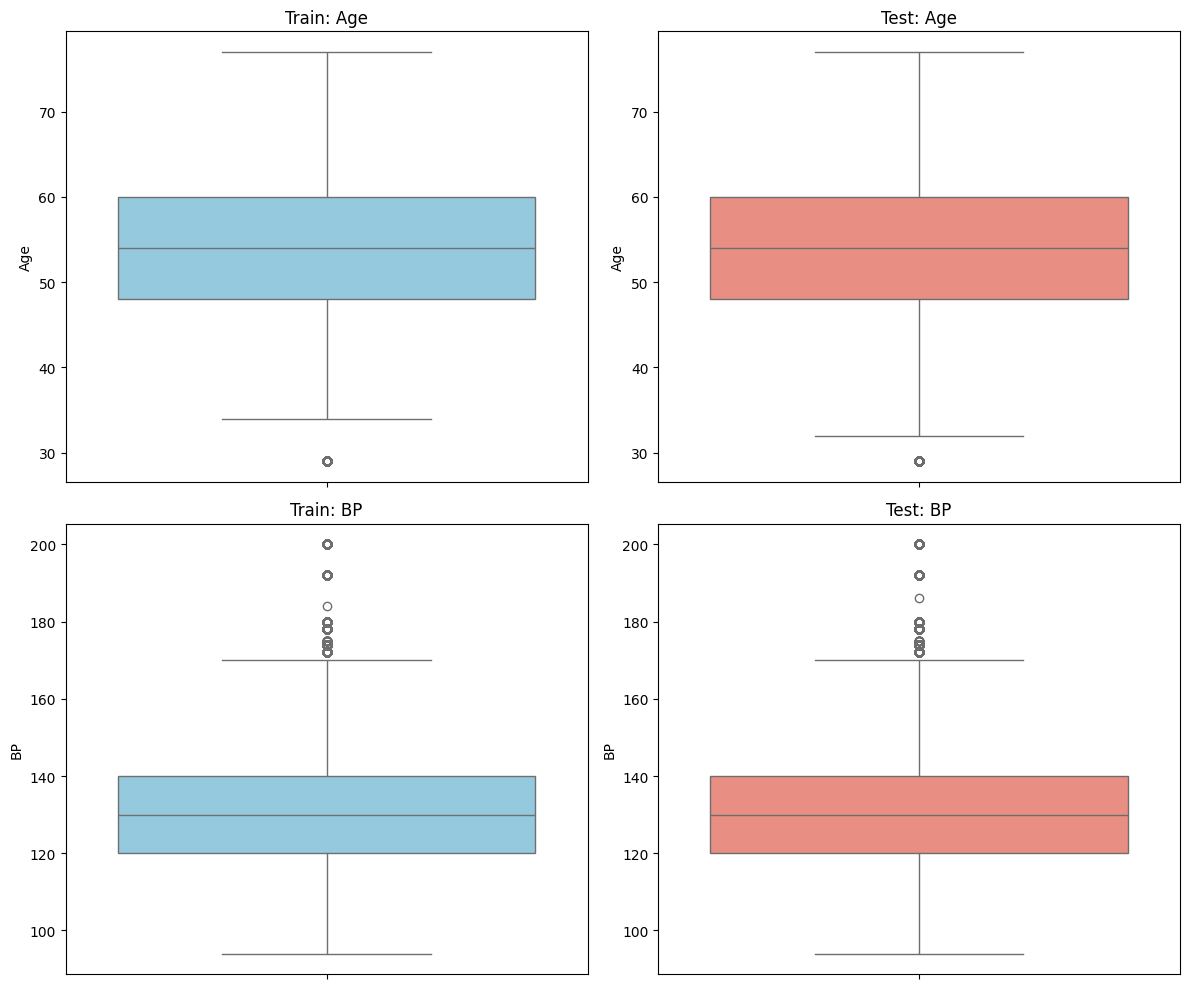

In [12]:
def plot_outliers(train_df, test_df, feature, feature_2):
    plt.figure(figsize=(12, 10))
    
    # Train Data
    plt.subplot(2, 2, 1)
    sns.boxplot(data=train_df, y=feature, color='skyblue')
    plt.title(f'Train: {feature}')
    
    # Test Data
    plt.subplot(2, 2, 2)
    sns.boxplot(data=test_df, y=feature, color='salmon')
    plt.title(f'Test: {feature}')

    # Train Data
    plt.subplot(2, 2, 3)
    sns.boxplot(data=train_df, y=feature_2, color='skyblue')
    plt.title(f'Train: {feature_2}')
    
    # Test Data
    plt.subplot(2, 2, 4)
    sns.boxplot(data=test_df, y=feature_2, color='salmon')
    plt.title(f'Test: {feature_2}')
    
    plt.tight_layout()
    plt.show()

plot_outliers(train, test, 'Age', 'BP')

Skewness for Age: -0.16


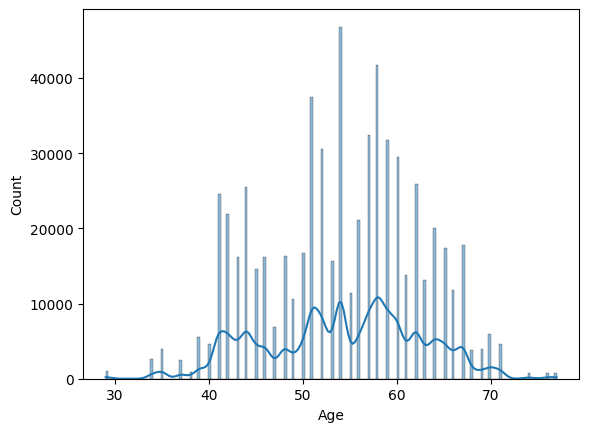

In [13]:
def check_skew(df, feature):
    print(f"Skewness for {feature}: {df[feature].skew():.2f}")
    sns.histplot(df[feature], kde=True)
    plt.show()

check_skew(train, 'Age')

Skewness for BP: 0.63


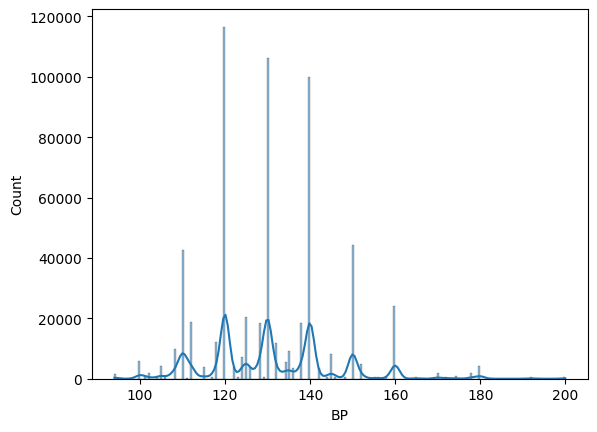

In [14]:
def check_skew(df, feature):
    print(f"Skewness for {feature}: {df[feature].skew():.2f}")
    sns.histplot(df[feature], kde=True)
    plt.show()

check_skew(train, 'BP')

Skewness for Max HR: -0.75


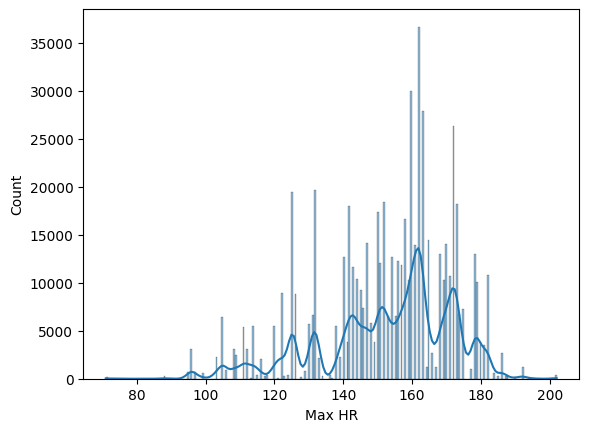

In [15]:
def check_skew(df, feature):
    print(f"Skewness for {feature}: {df[feature].skew():.2f}")
    sns.histplot(df[feature], kde=True)
    plt.show()

check_skew(train, 'Max HR')

Skewness for ST depression: 1.33


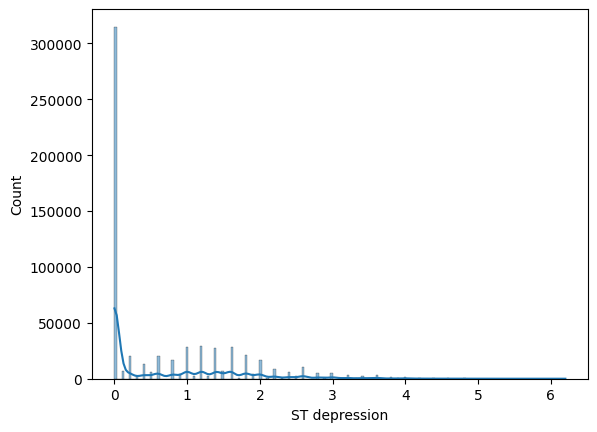

In [16]:
def check_skew(df, feature):
    print(f"Skewness for {feature}: {df[feature].skew():.2f}")
    sns.histplot(df[feature], kde=True)
    plt.show()

check_skew(train, 'ST depression')

# <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🏷️ Encode Target Variable</span>

In [17]:
# Encode target
le = LabelEncoder()
train['Heart Disease'] = le.fit_transform(train['Heart Disease']) 

In [18]:
train.head(3)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0


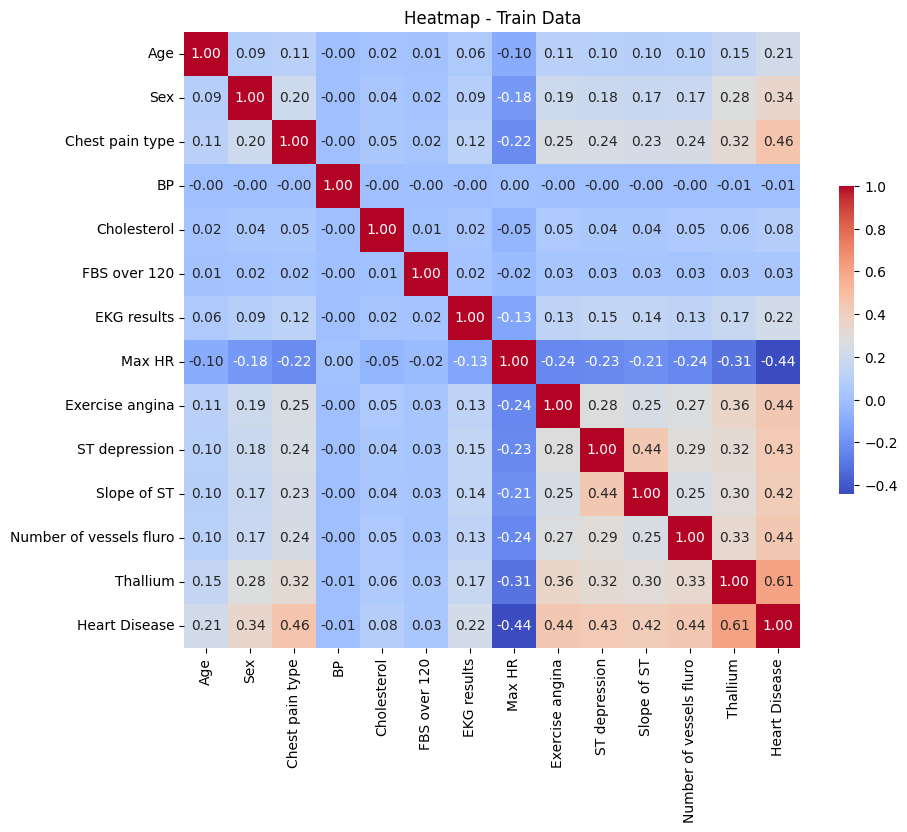

In [19]:
corr_train = train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_train, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.title("Heatmap - Train Data")
plt.show()

# <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🎯 Predict Target</span>

In [20]:
X = train.drop(['Heart Disease'], axis=1)
y = train['Heart Disease']

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  💡 Logistic Regression</span>

In [21]:
# from sklearn.linear_model import LogisticRegression

# # 1. Split the data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=5)

# # 2. Initialize Logistic Regression
# # We use 'liblinear' or 'lbfgs' solvers for small to medium datasets
# model = LogisticRegression(
#     max_iter=1000, 
#     random_state=5,
#     C=1.0  # Regularization strength
# )

# # 3. Train the model
# model.fit(X_train, y_train)

# # 4. Predict on the test set
# preds = model.predict(test)

# # 5. Save results
# sample_submission['Heart Disease'] = preds
# sample_submission.to_csv('submission.csv')

# print("Logistic Regression training complete!")



######################
### RESULT: 0.87715
######################

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🌲 Decision Tree</span>

In [22]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split

# # 1. Split the data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=5)

# # 2. Initialize Decision Tree Classifier
# clf = DecisionTreeClassifier(
#     max_depth=5,            # Shallow depth helps prevent overfitting
#     min_samples_split=2,    # Minimum samples required to split a node
#     criterion='gini',       # Metric to measure quality of split
#     random_state=5
# )

# # 3. Train the model
# clf.fit(X_train, y_train)

# # 4. Predict and Save
# preds = clf.predict(test)
# sample_submission['Heart Disease'] = preds
# sample_submission.to_csv('submission.csv')

# print("Decision Tree training complete!")



######################
### RESULT: 0.85849
######################

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🌳🌲 Random Forest</span>

In [23]:
# from sklearn.ensemble import RandomForestClassifier

# # 1. Split the data
# # Note: We don't strictly need X_val for early stopping in RF, 
# # but we'll keep the split to check accuracy.
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=5)

# # 2. Initialize Random Forest Classifier
# clf = RandomForestClassifier(
#     n_estimators=500,       # Number of trees in the forest
#     max_depth=8,            # Max depth of each tree
#     min_samples_leaf=1,     # Equivalent to min_child_weight logic
#     max_features='sqrt',    # Number of features to consider at each split
#     bootstrap=True,         # Use bagging
#     n_jobs=-1,              # Uses ALL available CPU cores (Random Forest doesn't use CUDA)
#     random_state=5
# )

# # 3. Train the model
# clf.fit(X_train, y_train)

# # 4. Predict and Save
# preds = clf.predict(test)
# sample_submission['Heart Disease'] = preds
# sample_submission.to_csv('submission.csv')

# # Optional: Check validation score
# val_score = clf.score(X_val, y_val)
# print(f"Validation Accuracy: {val_score:.4f}")



######################
### RESULT: 0.87760
######################

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🎓 XGBClassifier</span>

In [24]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=5)

# clf = xgb.XGBClassifier(
#     max_depth=8,
#     min_child_weight=1,
#     gamma=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_alpha=0.1,
#     reg_lambda=1,
#     learning_rate=0.1,    
#     n_estimators=2000,    # Start with a large number and use early stopping
#     random_state=5,
#     device="cuda", 
#     objective= "binary:logistic",
#     tree_method = "auto",
#     eval_metric="logloss",      # Metric to evaluate
#     early_stopping_rounds=10,   # Stop if no improvement in 10 rounds
# )

# preds = clf.fit(
#     X_train, y_train, 
#     eval_set=[(X_val, y_val)],  # Validation data to monitor
#     verbose=True               # Print progress
# )

# preds = clf.predict(test)
# sample_submission['Heart Disease'] = preds
# sample_submission.to_csv('submission.csv')



######################
### RESULT: 0.88325
######################

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🏅 LGBMClassifier</span>

In [25]:
# import lightgbm as lgb

# # 1. Split the data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=5)

# # 2. Initialize LightGBM Classifier
# clf = lgb.LGBMClassifier(
#     max_depth=8,
#     num_leaves=31,          # Important for LightGBM (roughly 2^max_depth)
#     min_child_samples=1,    # Equivalent to min_child_weight
#     learning_rate=0.1,
#     n_estimators=2000,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_alpha=0.1,
#     reg_lambda=1,
#     random_state=5,
#     device="gpu",           # Enables GPU acceleration
#     objective="binary",
#     importance_type='gain',
#     verbosity=-1            # Reduces unnecessary logs
# )

# # 3. Fit the model with Early Stopping
# # Note: LightGBM uses callbacks for early stopping in newer versions
# clf.fit(
#     X_train, y_train,
#     eval_set=[(X_val, y_val)],
#     eval_metric="binary_logloss",
#     callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
# )

# # 4. Predict and Save
# preds = clf.predict(test)
# sample_submission['Heart Disease'] = preds
# sample_submission.to_csv('submission.csv', index=False)



######################
### RESULT: 0.88400
######################

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  ⭐ LGBMClassifier Optimized</span>

In [26]:
# import lightgbm as lgb

# # 1. Split the data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=5)

# # 2. Initialize LightGBM Classifier
# clf = lgb.LGBMClassifier(
#     n_estimators=1000,
#     learning_rate=0.1,
#     num_leaves=151,         # Note: With max_depth=3, leaves are capped at 8 (2^3)
#     max_depth=3,
#     min_child_samples=86,
#     subsample=0.93,
#     colsample_bytree=0.516,
#     random_state=5,         # Maintaining consistency for reproducibility
#     device="gpu",           # GPU acceleration enabled
#     objective="binary",
#     importance_type='gain',
#     verbosity=-1            # Keeps the notebook output clean
# )

# # 3. Fit the model with Early Stopping
# # Note: LightGBM uses callbacks for early stopping in newer versions
# clf.fit(
#     X_train, y_train,
#     eval_set=[(X_val, y_val)],
#     eval_metric="binary_logloss",
#     callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
# )

# # 4. Predict and Save
# preds = clf.predict(test)
# sample_submission['Heart Disease'] = preds
# sample_submission.to_csv('submission.csv')



######################
### RESULT: 0.88442
######################

In [27]:
# sample_submission.head()

# <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;"> 🗃️ Stacking XGB, LGBM, Log Reg</span>

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🏷️ Preprocessing</span>

In [28]:
def check_missing(df, name="Dataset"):
    print(f"--- Missing Value Report: {name} ---")
    null_count = df.isnull().sum()
    null_percent = (df.isnull().sum() / len(df)) * 100
    
    # Combine into a table
    report = pd.concat([null_count, null_percent], axis=1, keys=['Total NaN', 'Percent (%)'])
    
    # Only show columns that actually have missing values
    return report[report['Total NaN'] > 0].sort_values(by='Total NaN', ascending=False)

# Usage:
print(check_missing(train, "Train"))
print(check_missing(test, "Test"))

--- Missing Value Report: Train ---
Empty DataFrame
Columns: [Total NaN, Percent (%)]
Index: []
--- Missing Value Report: Test ---
Empty DataFrame
Columns: [Total NaN, Percent (%)]
Index: []


In [29]:
# oh_enc_cols = X.columns.to_list()
# oh_enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# oh_train = pd.DataFrame(oh_enc.fit_transform(X[oh_enc_cols]))
# X[oh_train.columns.astype(str)] = oh_train.astype(int).astype('category')

# oh_test= pd.DataFrame(oh_enc.transform(test[oh_enc_cols]))
# test[oh_test.columns.astype(str)] = oh_test.astype(int).astype('category')

In [30]:
# X.head()

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  ⚙️ Feature Engineering</span>

In [31]:
def apply_feature_engineering(df):

    # 1. Product Interaction
    # High BP and high Cholesterol are both risk factors. Multiplying them creates a "compounding effect" 
    # where the risk score grows significantly if both are high, rather than just adding them linearly.
    df['bp_chol_index'] = df['BP'] * df['Cholesterol'] / 100.0

    # 2. Efficiency Ratio
    # Max heart rate naturally declines with age. This ratio measures how "young" a heart performs 
    # relative to actual age. The +1 prevents division by zero error.
    df['hr_age_ratio'] = df['Max HR'] / (df['Age'] + 1)
    
    # 3. Clinical Correlation
    # "Slope" indicates the quality of heart recovery. This helps the model differentiate between a 
    # "steep slope with low depression" and a "flat slope with high depression."
    df['st_slope_interaction'] = df['ST depression'] * df['Slope of ST']
    
    # 4. Severity Index
    #  Both features indicate physical blockages or defects. A high score flags patients with 
    # both multiple blocked vessels and a Thalassemia defect.
    df['vessel_thal_score'] = df['Number of vessels fluro'] * df['Thallium']
    
    # 5. Weighted Index Stress Test
    # It increases with high BP and severe ST depression (weighted to match BP's scale) but is 
    # offset by a high Max HR.
    df['heart_stress_index'] = (df['BP'] + df['ST depression'] * 10) / (df['Max HR'] + 1)
    
    # 6. Clinical Risk Buckets (Boolean Flags)
    # Hypertension Stage 2 is typically BP > 140
    df['is_hypertensive'] = (df['BP'] > 140).astype(int)
    
    # High Cholesterol is typically > 240
    df['high_cholesterol'] = (df['Cholesterol'] > 240).astype(int)
    
    # Elderly risk (Age > 60)
    df['is_elderly'] = (df['Age'] > 60).astype(int)

    # 7. Physiological Ratios & Indices
    # Double Product: Measures myocardial oxygen consumption
    df['double_product'] = df['BP'] * df['Max HR']
    
    # Heart Rate Reserve %: (Max HR achieved / Theoretical Max HR)
    # Theoretical Max HR is 220 - Age
    df['hr_reserve_pct'] = df['Max HR'] / (220 - df['Age'])

    # 8. Interaction Terms
    # Silent Killer: High sugar combined with high blood pressure
    df['sugar_pressure_inter'] = df['FBS over 120'] * df['BP']
    
    # Effort Impact: Pain triggered specifically by exercise
    df['effort_pain_impact'] = df['Chest pain type'] * df['Exercise angina']

    # 9. Metabolic Risk Score (Simple Tally)
    # Count of how many risk factors are present
    df['risk_factor_count'] = (
        (df['BP'] > 130).astype(int) + 
        (df['Cholesterol'] > 200).astype(int) + 
        (df['FBS over 120']).astype(int) +
        (df['is_elderly'])
    )

    # 10. EKG/Stress Red Flags
    # Flag for patients with both ST depression AND exercise-induced angina
    df['exercise_st_warning'] = ((df['ST depression'] > 0) & (df['Exercise angina'] == 1)).astype(int)
    
    # Simplify EKG: 0 = Normal, 1 = Abnormal
    df['abnormal_ekg_flag'] = (df['EKG results'] > 0).astype(int)

    return df

In [32]:
# Apply feature engineering to train and test data
# X = apply_feature_engineering(X)
# test = apply_feature_engineering(test)

cat_cols = ['Chest pain type', 'EKG results', 'Slope of ST', 'Thallium']

encoder_transformer = ColumnTransformer(
    transformers=[
        ('target_enc', TargetEncoder(random_state=42), cat_cols),
    ],
    remainder='passthrough'
)

preprocessor = Pipeline([
    ('encoder', encoder_transformer),
    ('scaler', StandardScaler())
])

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  📚 Stacking Models</span>

In [33]:
xgb_params = {
    'n_estimators': 1200, 
    'learning_rate': 0.04, 
    'max_depth': 5, 
    'min_child_weight': 5, 
    'subsample': 0.97, 
    'colsample_bytree': 0.516, 
    'gamma': 0.157, 
    # 'device':'cuda'
}

lgbm_params = {
    'n_estimators': 1100, 
    'learning_rate': 0.1, 
    'num_leaves': 151, 
    'max_depth': 3, 
    'min_child_samples': 86, 
    'subsample': 0.93, 
    'colsample_bytree': 0.516, 
    # 'device':'gpu', 
    'verbose': -1
}

estimators = [
    ('xgb', XGBClassifier(**xgb_params, random_state=42)),
    ('lgbm', LGBMClassifier(**lgbm_params, random_state=42))
]

stacking_model = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),
        stack_method='predict_proba',
        cv=5,
        n_jobs=-1
    ))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
stacking_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('target_enc',
                                                                   TargetEncoder(random_state=42),
                                                                   ['Chest '
                                                                    'pain type',
                                                                    'EKG '
                                                                    'results',
                                                                    'Slope of '
                                                                    'ST',
                                                                    'Thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=No...
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1200,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('lgbm',
                                                 LGBMClassifier(colsample_bytree=0.516,
                                                                max_depth=3,
                                                                min_child_samples=86,
                                                                n_estimators=1100,
                                                                num_leaves=151,
                                                                random_state=42,
                                                                subsample=0.93,
                                                                verbose=-1))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, stack_method='predict_proba'))])

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  ➰ ROC-AUC</span>

In [34]:
y_pred_proba = stacking_model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC: {auc:.4f}')

ROC-AUC: 0.9563


## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  🚅 Retrain on Complete Data</span>

In [35]:
print("Retraining on complete training data")
stacking_model.fit(X, y)

# Without Feature Engineering 0.95367
# With Feature Engineering and parameter optimization 0.95368

Retraining on complete training data


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('target_enc',
                                                                   TargetEncoder(random_state=42),
                                                                   ['Chest '
                                                                    'pain type',
                                                                    'EKG '
                                                                    'results',
                                                                    'Slope of '
                                                                    'ST',
                                                                    'Thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=No...
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1200,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('lgbm',
                                                 LGBMClassifier(colsample_bytree=0.516,
                                                                max_depth=3,
                                                                min_child_samples=86,
                                                                n_estimators=1100,
                                                                num_leaves=151,
                                                                random_state=42,
                                                                subsample=0.93,
                                                                verbose=-1))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, stack_method='predict_proba'))])

## <span style="color:#2980B9; font-family: 'Segoe UI'; border-left:5px solid #e65757; padding-left:10px; background-color:#F8F9F9; padding:10px; border-radius:5px;">  📥 Submit </span>

In [36]:
submission_csv = pd.DataFrame({
    'id': test['id'],
    'Heart Disease': stacking_model.predict_proba(test)[:, 1]
})

submission_csv.to_csv('submission.csv', index=False)

submission_csv.head()

,id,Heart Disease
0,630000,0.947997
1,630001,0.040338
2,630002,0.959241
3,630003,0.039455
4,630004,0.116133
